# Demo pipeline for STA evaluation of FACT (Vid001)

## Import essential packages

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from ModelInference.SWInf import sliding_window_inference 

from monai.config import print_config

from model.TS_Net_change import FACT_Net
from IO.ReadNii import load_nii_inference
from IO.Read_tif import load_tiff, load_tif_video
from PreProcessing.Filters import median_filter_parallel
from PreProcessing.Thresh import thresh_max

import torch
print_config()

import numpy as np
import SimpleITK as sitk
from PIL import Image

from PostSlice.Evaluation.STA_Eva import Evaluate_STA

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

MONAI version: 1.3.0
Numpy version: 1.24.4
Pytorch version: 2.1.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: d:\Anaconda\envs\fact_pub1\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.2
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.19.3
scipy version: 1.9.3
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0+cpu
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 1.5.3
einops version: 0.4.1
transformers version: 4.33.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing

In [2]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# print("GPU 编号: {}".format(device))
# print("GPU 名称: {}".format(torch.cuda.get_device_name(1)))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Code: {}".format(device))
print("GPU Name: {}".format(torch.cuda.get_device_name(0)))


GPU Code: cuda:0
GPU Name: NVIDIA GeForce RTX 3090


In [3]:
# Specifying the graphic card to use, especially when multiple GPUs exist in the same environment 
os.environ["CUDA_VISIBLE_DEVICE"] = "0"  
device = torch.device("cuda:0") 

## Load Image and Pre-process

### load image data

In [4]:
data_path = 'data/Demo/Vid001/Vid01.tiff'  
input_img = load_tiff(data_path)   

In [5]:
input_img.shape   

(600, 240, 240)

In [6]:
# Performing Normalization to the input video data   
input_img = (input_img-input_img.min())/(input_img.max()-input_img.min())   
# input_img = (input_img_ft-input_img_ft.min())/(input_img_ft.max()-input_img_ft.min())   

image shape: (600, 240, 240)


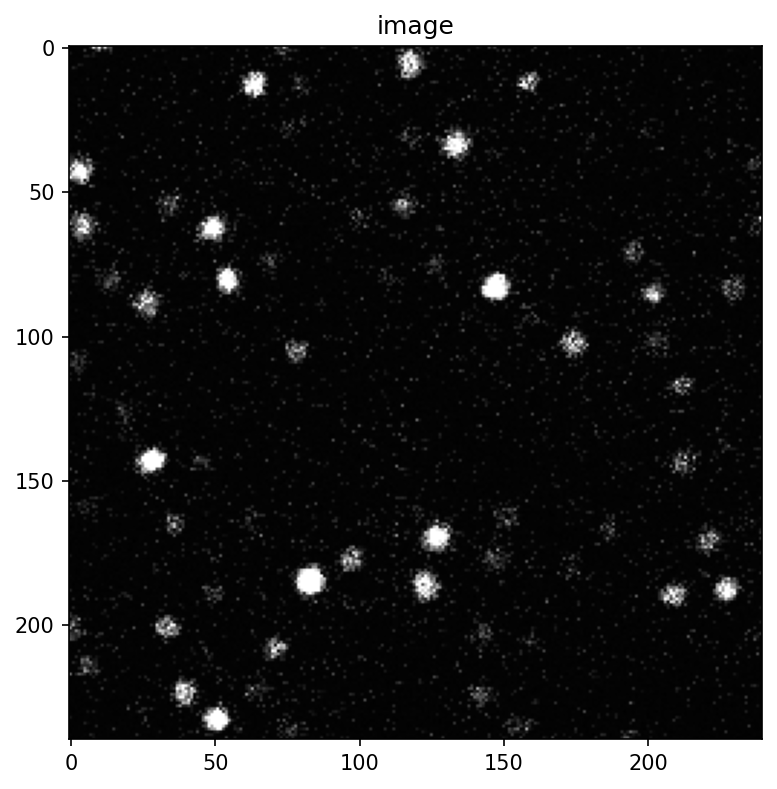

In [7]:
# Optional showtime: display data preview if required 
slice_num = 50  
img_shape = input_img.shape  
print(f"image shape: {img_shape}")  
plt.figure("image", (18, 6),dpi=150)  
plt.title("image")  
plt.imshow(input_img[slice_num, :, :], cmap="gist_gray")  
plt.show()  

## Model Inference

### Building up model and loading parameters

In [8]:
model_pth = "ModelParams/FACT_Modelparams.pt"
model = FACT_Net(
    img_size=(128,64,64),
    in_channels=1,
    out_channels=2,
    init_dim=3,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    use_checkpoint=True,
).to(device)

weight = torch.load(model_pth, map_location = 'cpu')
state_dict = weight["state_dict"]
model.load_state_dict(state_dict)

<All keys matched successfully>

#### Performing inference

In [9]:
input_img_tensor = torch.from_numpy(input_img)
model.eval()
with torch.no_grad():
    # test_inputs = torch.unsqueeze(input_img_tensor, 1).cuda(device=device)
    test_inputs = torch.unsqueeze(input_img_tensor, 0)
    test_inputs = torch.unsqueeze(test_inputs, 1)
    test_outputs = sliding_window_inference(
        test_inputs, (128, 64, 64), 32, model, overlap=[0.6,0.2,0.2], progress=True, mode="constant", 
        device=torch.device('cpu'), sw_device=device, 
    )

# device=torch.device('cpu')
torch.cuda.empty_cache()
print("Model Inference done")

  0%|          | 0/9 [00:00<?, ?it/s]torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
100%|██████████| 9/9 [00:05<00:00,  1.56it/s]

Model Inference done


In [10]:
thresh = 0
diff = test_outputs[0,1,:,:,:] -  test_outputs[0,0,:,:,:]
infer_mask3d = np.zeros(diff.shape, dtype=np.int16)
infer_mask3d[torch.where(diff>thresh)] = 1

raw_vid = input_img[:,:,:]  # saving the raw video to the pre-defined variable for further segmenting and refinning the inferred masks using the post-processing methods defined
raw_vid = raw_vid.transpose(1,2,0)  # transpose to make time the last dimension, in compatible with the post-processing procedure
infer_mask3d = infer_mask3d.transpose(1,2,0)

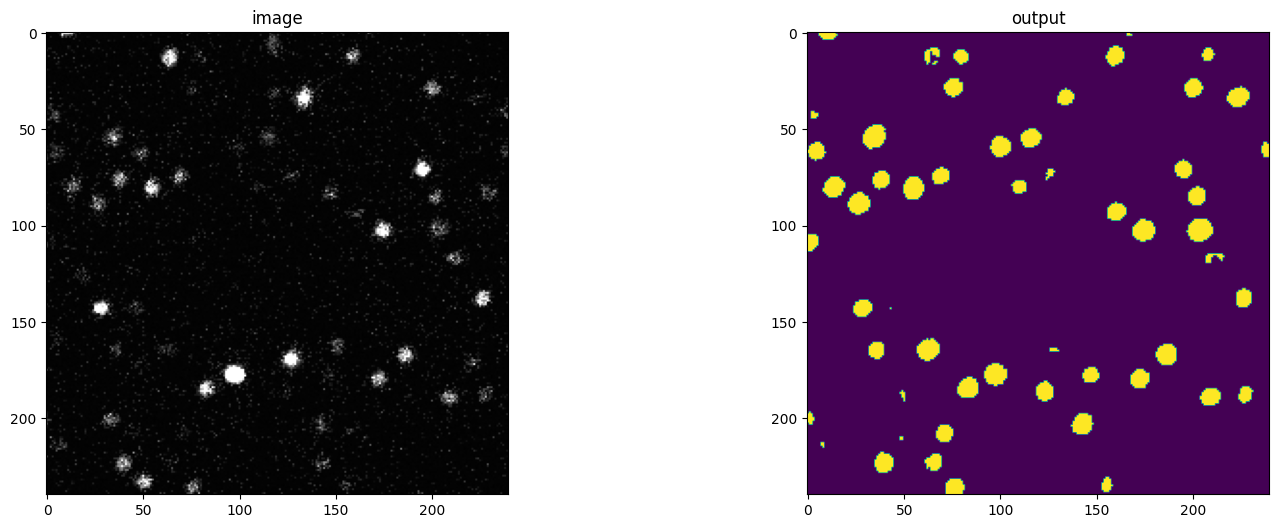

In [11]:
# Optional: show model inference results
slice_num = 100
plt.figure("check", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
# plt.imshow(test_inputs.cpu().numpy()[0, 0, slice_num, :, :], cmap="gray")
plt.imshow(raw_vid[:, :, slice_num], cmap="gray")
#     plt.subplot(1, 2, 2)
#     plt.title("label")
#     plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
plt.subplot(1, 2, 2)
plt.title("output")
plt.imshow(
    infer_mask3d[:, :, slice_num]
)
plt.show()

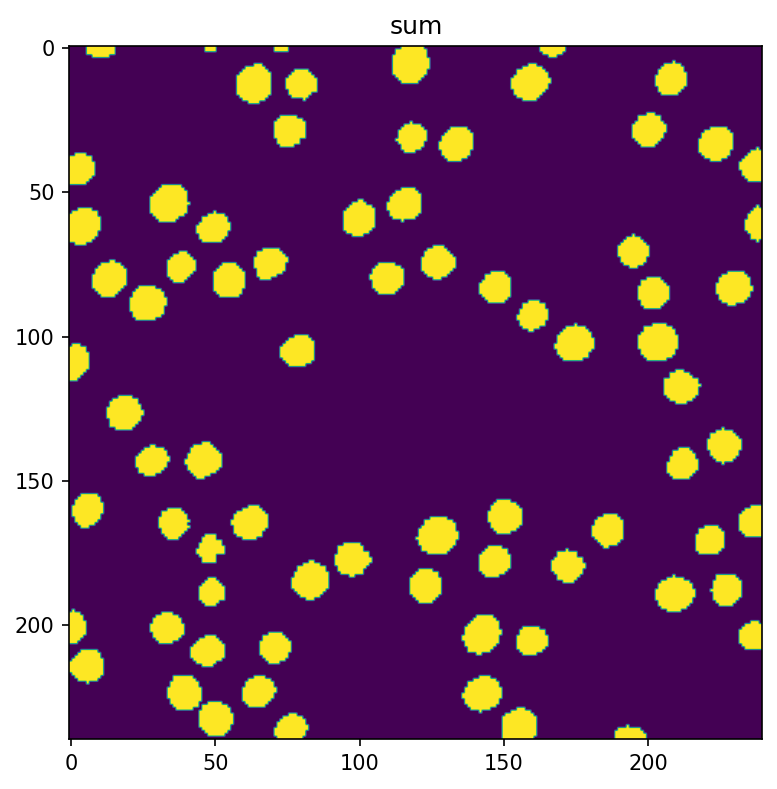

In [12]:
# Optional: show inference summation map 
summationmap = infer_mask3d.sum(axis=2)
summationmap[np.where(summationmap>0)] = 1
plt.figure("summation", (18, 6), dpi=150)
plt.title("sum")
plt.imshow(summationmap)
plt.show()

#### save Inference results

In [13]:
infer_mask3d.shape

(240, 240, 600)

In [14]:
# Fetch data filename and save path
data_dir = os.path.split(data_path)[0]
data_name = os.path.splitext(os.path.split(data_path)[1])[0]
print(f'data dir is "{data_dir}", data name is "{data_name}"')
infer_dir = data_dir  
# infer_dir = 'data\Test_CA1\DualPlaneTPMData_2022-08-10 Thy1-Gcamp_C1V1_CA1-DualPlane_Region3_file1_CH1_GoodQuality'  
save_infer_filepth = os.path.join(infer_dir, data_name)

np.savez(save_infer_filepth+'_Prediction3d.npz', infer_mask3d=infer_mask3d)

data dir is "data/Demo/Vid001", data name is "Vid01"


### Evaluate spatio-temporal accuracy

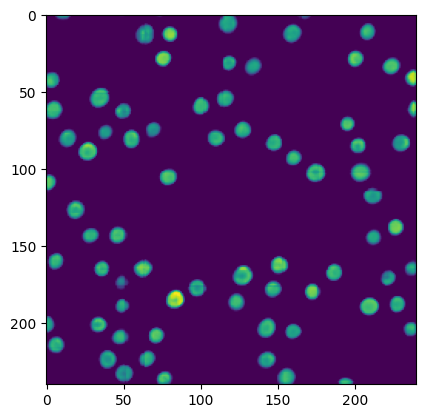

In [15]:
npz_data = np.load(save_infer_filepth+'_Prediction3d.npz', allow_pickle=True)
infer_mask3d = npz_data['infer_mask3d']
sum = infer_mask3d.sum(axis=2)
plt.imshow(sum)

In [16]:
ret = Evaluate_STA(mat_path='data/Demo/Vid001/GT/Vid01.mat' \
              ,npz_path=save_infer_filepth+'_Prediction3d.npz')

In [17]:
STA = np.average(ret['STA_all'])
print(f'The TSA of this video is {STA}')

The TSA of this video is 0.8355627705627706


In [18]:
ret['STA_all']

array([0.88666667, 0.93666667, 0.87333333, 0.805     , 0.91      ,
       0.36333333, 0.88333333, 0.815     , 0.825     , 0.93833333,
       0.86333333, 0.82333333, 0.845     , 0.80833333, 0.59166667,
       0.77166667, 0.81833333, 0.91      , 0.89333333, 0.36833333,
       0.90666667, 0.76166667, 0.90833333, 0.87333333, 0.87833333,
       0.76166667, 0.95666667, 0.86      , 0.86      , 0.86333333,
       0.87666667, 0.89666667, 0.86333333, 0.82666667, 0.445     ,
       0.82666667, 0.86333333, 0.81      , 0.89      , 0.855     ,
       0.865     , 0.945     , 0.89166667, 0.76666667, 0.935     ,
       0.935     , 0.89      , 0.82166667, 0.88833333, 0.855     ,
       0.925     , 0.85166667, 0.95333333, 0.86333333, 0.85833333,
       0.77833333, 0.89333333, 0.17666667, 0.86666667, 0.89833333,
       0.93666667, 0.825     , 0.83333333, 0.87666667, 0.81666667,
       0.90833333, 0.84333333, 0.895     , 0.80333333, 0.84333333,
       0.935     , 0.915     , 0.84833333, 0.76666667, 0.935  